In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import detrend

# Load CSV file
def load_data(filename):
    """
    Load voltage vs. time data from a CSV file.
    Assumes the file has columns: Time (s), Channel 1 (V), Channel 2 (V).
    """
    
    try:
        # Load the CSV with proper header handling
        data = pd.read_csv(filename, skiprows=24)  # First row is the header
        data.columns = data.columns.str.strip()  # Clean up column names

        # Extract relevant columns
        time = data["Time (s)"]
        tia = data["Channel 1 (V)"]
        bpf = data["Channel 2 (V)"]
        da = data["Channel 3 (V)"]
        levelShifter = data["Channel 4 (V)"]

        return time, tia, bpf, da, levelShifter
    except pd.errors.ParserError as e:
        print(f"ParserError: {e}")
        raise
    except KeyError as e:
        print(f"KeyError: {e}. Check column names in the CSV file.")
        raise

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend

# Calculate RMS voltage
def calculate_rms(voltage):
    return np.sqrt(np.mean(np.square(voltage)))

# Compute SNR
def calc_snr(signal, noise):
    signal_rms = calculate_rms(signal)
    noise_rms = calculate_rms(noise)
    return 10 * np.log10(signal_rms / noise_rms)

# Perform FFT and apply a frequency mask
def fft_bandpass_filter(signal, sampling_rate, target_freq, bandwidth=5000):
    """
    Filters the signal in the frequency domain using a bandpass mask.
    - target_freq: The frequency of interest (Hz)
    - bandwidth: The range around the target frequency to keep
    """
    N = len(signal)
    fft_output = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)

    # Create a mask that keeps only frequencies within the specified bandwidth
    mask = (np.abs(freqs) >= (target_freq - bandwidth/2)) & (np.abs(freqs) <= (target_freq + bandwidth/2))

    # Apply the mask (zero out unwanted frequencies)
    filtered_fft = fft_output * mask

    # Inverse FFT to get filtered signal
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal, freqs, np.abs(fft_output), np.abs(filtered_fft)


In [39]:
def process_data_and_snr(filename, signal_start, signal_end, led_freq, sampling_rate, bandwidth=50):
    """
    Processes the signal by filtering around the LED frequency in the frequency domain
    and calculates SNR for each channel.
    """
    # Load data
    time, tia, bpf, da, levelShifter = load_data(filename)

    # Get the signals for the specified time range
    tia_signal = tia[(time >= signal_start) & (time <= signal_end)]
    bpf_signal = bpf[(time >= signal_start) & (time <= signal_end)]
    da_signal = da[(time >= signal_start) & (time <= signal_end)]
    levelShifter_signal = levelShifter[(time >= signal_start) & (time <= signal_end)]

    # Detrend signals
    tia_no_dc = detrend(tia_signal)
    bpf_no_dc = detrend(bpf_signal)
    da_no_dc = detrend(da_signal)
    levelShifter_no_dc = detrend(levelShifter_signal)

    # Apply Fourier domain bandpass filtering
    filtered_tia, _, _, _ = fft_bandpass_filter(tia_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_bpf, _, _, _ = fft_bandpass_filter(bpf_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_da, _, _, _ = fft_bandpass_filter(da_no_dc, sampling_rate, led_freq, bandwidth)
    filtered_ls, _, _, _ = fft_bandpass_filter(levelShifter_no_dc, sampling_rate, led_freq, bandwidth)

    # Calculate noise for each stage (residual signal)
    noise_tia = tia_no_dc - filtered_tia
    noise_bpf = bpf_no_dc - filtered_bpf
    noise_da = da_no_dc - filtered_da
    noise_ls = levelShifter_no_dc - filtered_ls

    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle('Stacking noise and filtered signals')
    ax1.plot(time[:500], bpf_no_dc[:500], label='Noise')
    ax2.plot(time[:500], filtered_bpf[:500], label="bpf_filtered")
    ax3.plot(time[:500], noise_bpf[:500], label="bpf_noise")
    # plt.plot(time, tia_no_dc, label='Original Signal')
    # plt.plot(time, filtered_tia, label='Filtered Signal')
    plt.show()

    # Calculate SNR for each stage
    snr_tia = calc_snr(filtered_tia, noise_tia)
    snr_bpf = calc_snr(filtered_bpf, noise_bpf)
    snr_da = calc_snr(filtered_da, noise_da)
    snr_ls = calc_snr(filtered_ls, noise_ls)

    # Return SNR values and filtered signals if needed
    return snr_tia, snr_bpf, snr_da, snr_ls


In [20]:
# process the data 
import os

signal_start = -0.035
signal_end = 0.037
noise_start = -0.035
noise_end = 0.037
sampling_freq = 473934 # corrected from the csv file

Processing file '/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/data_processing/March 12 Water Tests/mar12_water_test4.csv'


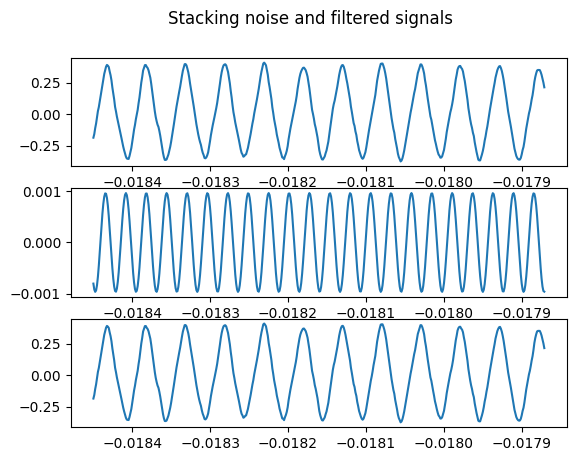

[np.float64(-27.21887852855378), np.float64(-27.627118513955683), np.float64(-27.479107892332756), np.float64(-26.906543188706173)]


In [42]:
file = "/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/data_processing/March 12 Water Tests/mar12_water_test4.csv"
print(f"Processing file '{file}'")
snr_tia, snr_bpf, snr_da, snr_ls = process_data_and_snr(file, signal_start, signal_end, 21e3, sampling_freq)
channels = ['TIA', 'BPF', 'DA', 'Level Shifter']
snr_values = [snr_tia, snr_bpf, snr_da, snr_ls]
print(snr_values)


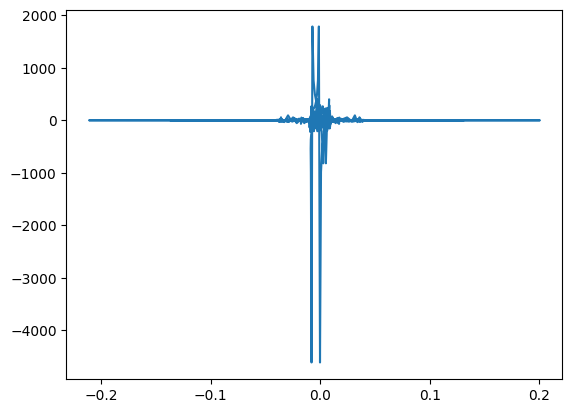

In [52]:
time, tia, bpf, da, levelShifter = load_data(file)
bpf_signal = bpf[(time >= signal_start) & (time <= signal_end)]
bpf_no_dc = detrend(bpf_signal)

N = len(bpf_no_dc)
fft_output = np.fft.fft(bpf_no_dc).real
freqs = np.fft.fftfreq(N, 1 / bpf_no_dc)
plt.plot(freqs, fft_output)
plt.show()

In [ ]:
# # calculate the RMS voltage
# def calculate_rms(voltage):
#     return np.sqrt(np.mean(np.square(voltage)))

# def calc_snr(signal, noise):
#     signal_rms = calculate_rms(signal)
#     noise_rms = calculate_rms(noise)

#     return 10 * np.log10(signal_rms / noise_rms)


In [ ]:

# from scipy.signal import butter, filtfilt

# def bandpass_filter(data, lowcut, highcut, fs, order=2):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     return filtfilt(b, a, data)


In [ ]:
# # process the csv data 
# def process_data(filename, signal_start, signal_end, bandwidth, led_freq, sampling_rate):
#     """
#     - filename: path to the csv file 
#     - signal_start, signal_end: time range for signal
#     - noise_start, noise_end: time range for noise
#     """
    
#     time, channel1, channel2 = load_data(filename)

#     photodiode_signal = channel2[(time >= signal_start) & (time <= signal_end)] # that's on channel 2 of the scope


#     # Plot data
#     signal_no_dc = detrend(photodiode_signal)
#     fftResult, freqs, peak_freq = calc_peak_freq(signal_no_dc, sampling_rate)


#     print(f"Max FFT Amplitude: {np.max(fftResult)}")
#     # print(f"Peak Frequency Index: {np.argmax(fftResult)}")
#     print(f"Peak Frequency (Hz): {peak_freq}")

#     print(f"Sampling Frequency: {sampling_rate}")
#     print(f"Signal Length: {len(signal_no_dc)}")

#     plt.plot(freqs, fftResult)
#     plt.title("Frequency Spectrum")
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Amplitude")
#     plt.show()

#     w = (led_freq * 7)/ (sampling_rate / 2) # Normalize the frequency
#     b, a = butter(5, w, 'low')
#     filtered_signal = filtfilt(b, a, signal_no_dc)

#     # Noise can be estimated by subtracting the filtered signal
#     noise = signal_no_dc - filtered_signal
#     print(f"Noise variance: {np.var(noise)}")
#     print(f"Filtered Signal Min: {np.min(filtered_signal)}, Max: {np.max(filtered_signal)}")
#     print(f"Noise Min: {np.min(noise)}, Max: {np.max(noise)}")

#     # assert 0 < lowcut < sampling_rate/2 and 0 < highcut < sampling_rate/2, "Cutoff frequencies must be valid."

#     # Filter the photodiode signal
#     #filtered_signal = bandpass_filter(photodiode_signal, lowcut, highcut, sampling_rate)

#     snr = calc_snr(filtered_signal, noise)

#     print(f"SNR value: {snr:.2f}")

#     plt.figure(figsize=(8,4))
#     plt.plot(time, photodiode_signal, label='Original Signal')
#     plt.plot(time, filtered_signal, label='Filtered Signal')
#     plt.plot(time, noise, label='Noise')
#     plt.legend()
#     plt.ylabel("Voltage Amplitude (V)")
#     plt.xlabel("Time (s)")
#     plt.show()

#     def psd_plot(photodiode_signal, fs):

#         # Compute PSD using Welch's method
#         frequencies, psd = welch(photodiode_signal, fs, nperseg=len(signal_no_dc)//2)

#         # Plot the PSD
#         plt.figure(figsize=(8, 4))
#         plt.semilogy(frequencies, psd)  # semilogy for better visualization
#         plt.xlabel("Frequency (Hz)")
#         plt.ylabel("Power Spectral Density (V²/Hz)")
#         plt.title("Power Spectral Density (PSD) of Signal")
#         plt.grid()
#         plt.show()
    
#     psd_plot(signal_no_dc, sampling_rate)


#     return snr

In [ ]:
# process the data 
import os

data_directory = "/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/testData/"
signal_start = 0.99
signal_end = 1.1
noise_start = 0.99
noise_end = 1.1
sampling_freq = 5e7 # corrected from the csv file
bandwidth = 7000

# # process data 
# # Iterate over files in directory
# for name in os.listdir(data_directory):
#     # Open file
#     with open(os.path.join(data_directory, name)) as f:
#         print(f"Processing file '{name}'")
#         snr = process_data(os.path.join(data_directory, name), signal_start, signal_end, bandwidth, freqs[idx], sampling_freq)
#         snr_arr.append(snr)
#         idx += 1


In [ ]:

# Iterate over files in directory
# for name in os.listdir(data_directory):
#     # Open file
#     with open(os.path.join(data_directory, name)) as f:

file = "/Users/mac/Desktop/Capstone/2465-Underwater-LiFi/testData/10kHz0_5cm_LED1.csv"
print(f"Processing file '{file}'")
snr = process_data(file, signal_start, signal_end, bandwidth, 1e4, sampling_freq)

